## Set random seed to get more reproducible result

In [1]:
from numpy.random import seed
seed(2)
from tensorflow.random import set_seed
set_seed(2)

## Import libraries and functions

In [2]:
import os
import numpy as np
import pandas as pd

from expert.src.utils import read_genus_abu, read_labels, load_otlg, zero_weight_unk, parse_otlg, get_dmax
from expert.src.preprocessing import *
from expert.src.model import *
from expert.CLI.CLI_utils import find_pkg_resource as find_expert_resource

from tensorflow.keras.layers import Dense, Dropout, AlphaDropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.initializers import HeUniform, GlorotUniform

In [378]:
info1 = pd.read_csv('dataFiles/filereport_read_run_PRJNA392012.tsv', sep='\t')
info2 = pd.read_csv('dataFiles/HADZA_MAPPING_350_20201210_9am.csv')
info1['#SampleID'] = info1.sample_alias.str.lstrip('TZHADZA_').astype(int)
meta = pd.merge(left=info1, right=info2, on='#SampleID').drop(columns=['sample_accession', 'experiment_accession', 'scientific_name', 'fastq_ftp', 'submitted_ftp', 
                                                                'sra_ftp', 'Study', 'Country', 'Population']
                                                      ).set_index('run_accession').loc[abu.columns.tolist(), :]
meta = meta[meta.Metagenomics != 'Yes']
meta.index.name = 'SampleID'
meta.to_csv('dataFiles/samples_meta.csv')
abu.loc[:, meta.index.tolist()].to_csv('dataFiles/species_abundance.tsv', sep='\t')

In [380]:
meta = pd.read_csv('dataFiles/samples_meta.csv')
meta['Env'] = 'root:'+ meta.SEASON.str.lstrip('20134-LE')
meta.to_csv('dataFiles/samples_meta_new.csv')
abu = abu.loc[:, meta.SampleID]
abu.to_csv('dataFiles/species_abundance.tsv', sep='\t')

In [354]:
queries_2 = ['SRR5761120', 'SRR5760853', 'SRR5761144', 'SRR5760882', 'SRR5761191']
meta.loc[meta.SampleID.isin(queries_2), :].to_csv('experiments/QueryMapper2.csv')
abu.loc[:, abu.columns.to_series().isin(queries_2)].to_csv('experiments/QueryCM2.tsv', sep='\t')

abu_rest = abu.loc[:, ~abu.columns.to_series().isin(queries_2)]
mapper = meta[~meta.SampleID.isin(queries_2)]

for exp, season in enumerate(['2013-LD', '2014-EW', '2014-LW', '2014-ED', '2014-LD']):
    queries_1 = mapper.groupby(by='SEASON').sample(frac=0.1).SampleID
    mapper[mapper.SampleID.isin(queries_1)].to_csv('experiments/exp_{}/QueryMapper1.csv'.format(exp))
    abu_rest[queries_1].to_csv('experiments/exp_{}/QueryCM1.tsv'.format(exp), sep='\t')
    mapper[~mapper.SampleID.isin(queries_1)].to_csv('experiments/exp_{}/SourceMapper.csv'.format(exp))
    abu_rest.loc[:, ~abu_rest.columns.to_series().isin(queries_1)].to_csv('experiments/exp_{}/SourceCM.tsv'.format(exp), sep='\t')

## Construct ontology using mapper file of source samples

In [355]:
!expert construct -i microbiomes.txt -o ontology.pkl

Reading microbiome structure...
Generating Ontology...
100%|██████████████████████████████████████████| 2/2 [00:00<00:00, 11881.88it/s]
root
├── root:D
└── root:W

Done


## Preprocess the data, using EXPERT's command-line API 

In [356]:
%%bash

ls experiments/QueryCM2.tsv > tmp; expert convert -i tmp --in-cm -o experiments/QueryCM2.h5
expert map --to-otlg -t ontology.pkl -i experiments/QueryMapper2.csv -o experiments/QueryLabels2.h5
for i in {0,1,2,3,4}; do
ls experiments/exp_$i/SourceCM.tsv > tmp; expert convert -i tmp --in-cm -o experiments/exp_$i/SourceCM.h5;
ls experiments/exp_$i/QueryCM1.tsv > tmp; expert convert -i tmp --in-cm -o experiments/exp_$i/QueryCM1.h5;
expert map --to-otlg -t ontology.pkl -i experiments/exp_$i/SourceMapper.csv -o experiments/exp_$i/SourceLabels.h5;
expert map --to-otlg -t ontology.pkl -i experiments/exp_$i/QueryMapper1.csv -o experiments/exp_$i/QueryLabels1.h5;
done
rm tmp

running...
Reading and concatenating data, this could be slow if you have huge amount of data
db file: /home/chonghui/.etetoolkit/taxa.sqlite
       SRR5760853  SRR5760882  SRR5761120  SRR5761144  SRR5761191
count  487.000000  487.000000  487.000000  487.000000  487.000000
mean     0.353330    0.281948    0.357357    0.312273    0.274692
std      4.009807    3.354944    4.269951    2.352340    2.076948
min      0.000000    0.000000    0.000000    0.000000    0.000000
50%      0.000000    0.000000    0.000000    0.000000    0.000000
max     80.505304   69.899519   87.655334   40.719208   36.390414
Initializing in-memory taxonomy database for ultra-fast querying.
db file: /home/chonghui/.etetoolkit/taxa.sqlite
There will be 0/487 entries droped cause they are not in NCBI taxanomy database
Series([], dtype: object)
Extracting lineages for taxonomic entries, this may take a few minutes
Filling samples in phylogeny matrix
        SRR5760853   SRR5760882   SRR5761120   SRR5761144   SRR576119

100%|██████████| 2/2 [00:00<00:00, 36.51it/s]


## Evaluate the model

In [357]:
%%bash
for i in {0,1,2,3,4}; do
expert transfer -i experiments/exp_$i/SourceCM.h5 -t ontology.pkl -l experiments/exp_$i/SourceLabels.h5 -o experiments/exp_$i/AdaptModel_ft_DM \
        -m ../Disease-diagnosis/experiments/exp_3/TrainModel/ --finetune --update-statistics;
expert search -i experiments/exp_$i/QueryCM1.h5 -m experiments/exp_$i/AdaptModel_ft_DM -o experiments/exp_$i/SearchResult1;
expert search -i experiments/QueryCM2.h5 -m experiments/exp_$i/AdaptModel_ft_DM -o experiments/exp_$i/SearchResult2;
done

Reordering labels and samples...
Total matched samples: 179
Total correct samples: 179?179
           mean       std
0      0.000000  0.000000
1      0.000000  0.000000
2      0.000000  0.000000
3      0.006795  0.024863
4      0.006725  0.024869
...         ...       ...
18013  0.000114  0.000321
18014  0.000000  0.000000
18015  0.000285  0.001141
18016  0.000015  0.000087
18017  0.000000  0.000000

[18018 rows x 2 columns]
Training using optimizer with lr=0.001...
Epoch 1/300
3/3 [==============================] - 1s 204ms/step - loss: 0.8609 - acc: 0.4876 - auROC: 0.5436 - val_loss: 0.8064 - val_acc: 0.3611 - val_auROC: 0.4290
Epoch 2/300
3/3 [==============================] - 0s 44ms/step - loss: 0.7487 - acc: 0.4876 - auROC: 0.5080 - val_loss: 0.7464 - val_acc: 0.3611 - val_auROC: 0.4120
Epoch 3/300
3/3 [==============================] - 0s 38ms/step - loss: 0.7233 - acc: 0.4783 - auROC: 0.5102 - val_loss: 0.6944 - val_acc: 0.4444 - val_auROC: 0.5448
Epoch 4/300
3/3 [=============

2020-12-29 15:30:28.304371: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2020-12-29 15:30:28.312783: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2499960000 Hz
2020-12-29 15:30:28.315283: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x564ca6cadf70 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-12-29 15:30:28.315335: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-12-29 15:30:28.433598: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 73801728 exceeds 10% of free system memory.
2020-12-29 15:30:28.445780: W tensorflow/core/framework/cpu_allocator_impl.cc:81]

## Visualize the evaluation result

In [414]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

metadata = pd.read_csv('dataFiles/samples_meta_new.csv').set_index('SampleID')
metadata['COLLECTION_DATE'] = pd.to_datetime(metadata.COLLECTION_DATE)
sorted_months = metadata.COLLECTION_DATE.sort_values().copy()

c1 = pd.concat([pd.read_csv('experiments/exp_{}/SearchResult1/layer-2.csv'.format(i), index_col=0) for i in range(5)])
c2 = pd.concat([pd.read_csv('experiments/exp_{}/SearchResult2/layer-2.csv'.format(i), index_col=0).join(metadata, how='left').rename(index=lambda x: x+'_exp'+str(i)) for i in range(5)])

c1 = c1.join(metadata, how='left')
c1['group'] = 'reference'

/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


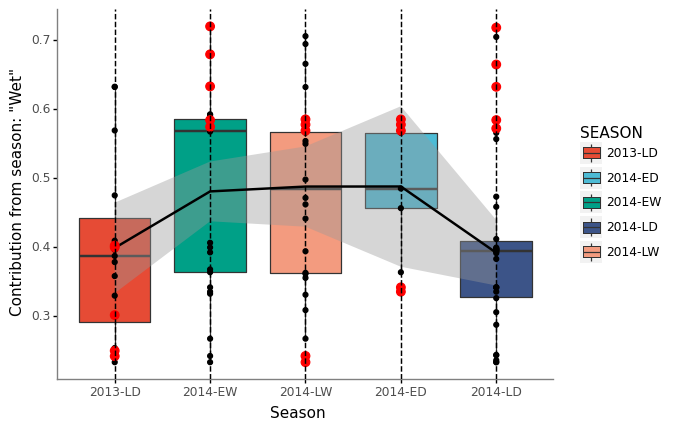

<ggplot: (8728116711193)>


/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: Figure.pdf
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


In [417]:
from plotnine import *

plot = (ggplot(c1, aes(x='SEASON', y='root:W'))
        + geom_boxplot(aes(fill='SEASON', group='SEASON'), outlier_shape='', show_legend=True)
        + scale_fill_manual(["#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF", "#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF"])
        #+ geom_boxplot(aes(group='Timepoint_str'), fill='white', alpha=0.5, show_legend=False, outlier_shape='', data=data[data.People != 'MT10'], width=0.4)
        + geom_smooth(aes(group='group'), se=True, method='loess', show_legend=True)
        #+ scale_linetype_manual(['solid', 'dashdot'])
        + geom_point(color='black')
        + geom_point(color='red', data=c2, shape='o', size=3)
        + scale_color_manual(['brown', "black"])
        + theme(panel_grid_major = element_blank(), panel_grid_minor = element_blank(), panel_background = element_blank(),
             axis_line_x = element_line(color="gray", size = 1), axis_line_y = element_line(color="gray", size = 1))
        #+ geom_hline(yintercept=, linetype="dotted")
        + geom_vline(xintercept=[1, 2, 3, 4, 5], linetype="dashed", size=0.6)
        #+ geom_label(data='Early back', position=[15.5, 0.2])
        + scale_x_discrete(limits=['2013-LD', '2014-EW', '2014-LW', '2014-ED', '2014-LD'])
        + xlab('Season')
        + ylab('Contribution from season: "Wet"')
)

print(plot)
plot.save('Figure.pdf', dpi=120, width=6.4*1, height=4.8)

In [428]:
meta[meta.SUBJECT_ID == 5]

,SampleID,study_accession,sample_alias,#SampleID,Gender,Age,COLLECTION_DATE,SEASON,BUSH_CAMP,Metagenomics,SEASONALITY_UNIQUE_ONLY_1,8_individuals,SUBJECT_ID,Env
60,SRR5760942,PRJNA392012,TZ_HADZA_267,267,FEMALE,45.0,1/30/2014,2014-EW,SENGELI,No,No,No,5,root:W
71,SRR5760958,PRJNA392012,TZ_HADZA_227,227,FEMALE,45.0,1/28/2014,2014-EW,SENGELI,No,No,No,5,root:W
132,SRR5761074,PRJNA392012,TZ_HADZA_139,139,FEMALE,45.0,9/7/2013,2013-LD,SENGELI,No,No,No,5,root:D
137,SRR5761079,PRJNA392012,TZ_HADZA_198,198,FEMALE,45.0,1/26/2014,2014-EW,SENGELI,No,Yes,No,5,root:W


## Plot the data distribution

In [631]:
meta.to_csv('Metadata_PCoA.csv')
abu.to_csv('abundance_PCoA.csv')
!python ../../UniPCoA/UniPCoA.py -i abundance_PCoA.csv -m Metadata_PCoA.csv \
    --metric jensenshannon -o Plots.JSD

#-t ../../UniPCoA/LTPs132_SSU_tree.newick 

Loading data...
Processing the abundance data...
Trying calculating jensenshannon beta_diversity using scikit-bio & scikit-learn package...
This could be time-consuming.
Failed, the metric you selected is not supported by neither scikit-bio nor scikit-learn.
Trying using SciPy...
Succeeded!
Visualizing the data using plotnine package...
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 4.8 x 4.8 in image.
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: Plots.JSD/PCoA.pdf
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 4.8 x 1 in image.
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: Plots.JSD/PC1_boxplot.pdf
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:727: P

In [165]:
metrics =[pd.read_csv('experiments/exp_{}/EvalResult_{}/overall.csv'.format(i, 'Adapt_ft_DM'), index_col=0).rename(columns=lambda x: '{}-exp_{}-{}'.format(x, i, 'Adapt_ft_DM')).dropna()
        for i in range(5)]
overall = pd.concat(metrics, axis=1)
overall
overall = overall.reset_index().melt(id_vars=['index'], value_vars=overall.columns.tolist(), var_name='metric').dropna()
overall['Experiment'] = overall['metric'].str.split('-').apply(lambda x: '{}'.format( x[3])).map({'Adapt_ft_DM': 'Transfer (DM)', 'Adapt_ft_HM': 'Transfer (HM)', 'Train': 'Independent'})
overall['Metric'] = overall['metric'].str.split('-').apply(lambda x: '{}-{}'.format(x[0], x[1]))
overall = overall[overall.Metric == 'ROC-AUC'].groupby(by='index', as_index=False).mean().round(4)
overall['index'] = overall['index'].apply(lambda x: x.split(' ')[2].rstrip(')'))
overall['ROC-AUC'] = overall['value']
overall['Stage'] = overall['index']

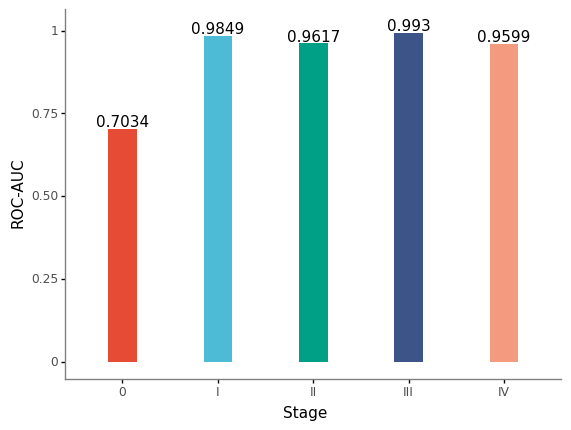

<ggplot: (8737241783248)>


/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 3.6 x 4.8 in image.
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: CRC_stage_performance.pdf


In [166]:
from plotnine import *
plot = (ggplot(overall, aes(x='Stage', y='ROC-AUC', fill='Stage'))
         + geom_bar(stat='identity', width=0.3, show_legend = False)
         + scale_fill_manual(['#E64B35FF','#4DBBD5FF','#00A087FF','#3C5488FF','#F39B7FFF','#8491B4FF','#91D1C2FF'])
         + geom_text(aes(label='value'), position=position_dodge(width=0.9), nudge_y=0.02)
         + theme(panel_grid_major = element_blank(), panel_grid_minor = element_blank(), panel_background = element_blank(),
                 axis_line_x = element_line(color="gray", size = 1), axis_line_y = element_line(color="gray", size = 1))
       )
print(plot)
plot.save('CRC_stage_performance.pdf', dpi=120, width=3.6, height=4.8)

In [174]:
pd.read_csv('dataFiles/species_abundance.csv', index_col=0).to_csv('dataFiles/species_abundance.tsv', sep='\t')
!ls dataFiles/species_abundance.tsv > tmp
!expert convert -i tmp -o CRC_cm.h5 --in-cm
!for i in {0,1,2,3,4}; do expert search -i CRC_cm.h5 -o CRC_contribution_$i -m ../Disease-diagnosis/experiments/exp_$i/TrainModel; done

running...
Reading and concatenating data, this could be slow if you have huge amount of data
db file: /home/chonghui/.etetoolkit/taxa.sqlite
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.45it/s]
        ERR475482   ERR475493   ERR475500  ...   ERR481063   ERR481064   ERR481065
count  854.000000  854.000000  854.000000  ...  854.000000  854.000000  854.000000
mean     0.188848    0.155293    0.091492  ...    0.221712    0.225143    0.222403
std      2.274977    1.508092    1.018507  ...    4.716516    4.774864    4.758246
min      0.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
50%      0.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
max     47.130700   37.035000   24.845200  ...  135.370960  137.099840  136.803670

[6 rows x 635 columns]
Initializing in-memory taxonomy database for ultra-fast querying.
db file: /home/chonghui/.etetoolkit/taxa.sqlite
There will be 0/854 entries droped cause they are not in N